In [1]:
import torch
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import random
rng = random.Random(42)

/home/jdias/miniconda3/envs/vf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load aux functions

In [2]:
#model loading functions

def choose_device(device):
    if device==0:
        return 'cuda:0'
    elif device==1:
        return 'cuda:1'
    elif device ==-1:
        return 'cpu'
    else:
        raise Exception('Return 0 or 1 for GPUs or -1 for CPU')

def load_device(cuda_id):
    cuda = choose_device(cuda_id)
    device = torch.device(cuda if torch.cuda.is_available() else "cpu")
    return device

def load_AutoModel(model_id,cuda_id):
    
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side = "left") 
    tokenizer.pad_token_id = tokenizer.eos_token_id #required in llama because no padding token is defined
    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    device = load_device(cuda_id)
    model = model.to(device)

    return tokenizer, model, device, terminators

In [3]:
#prompt related functions

def load_prompts(prompt_type, prompt_topic):
    #load prompt from .txt
    if prompt_type == 'completion':
        with open('../prompts-comp/'+prompt_topic+'.txt') as file:
            prompt = file.read()
    elif prompt_type == 'generation':
        with open('../prompts-gen/'+prompt_topic+'.txt') as file:
            prompt = file.read()
        prompt = json.loads(prompt, strict=False)
    return prompt

def prepare_llama_prompt(tokenizer, prompt, device):
    text = tokenizer.apply_chat_template(prompt, add_generation_prompt=True, tokenize=False) 
    inputs = tokenizer(text, padding="longest", return_tensors="pt") #transform into pt tensors
    inputs = {key: val.to(device) for key, val in inputs.items()} #move inputs into cuda
    return inputs

In [4]:
#pipeline functions

def compute_layer_vectors(layer_activation):
    return layer_activation[1:]-layer_activation[:-1] #matrix except first_row - matrix except last_row

def compute_vectors(hidden_states):
    return [compute_layer_vectors(layer) for layer in hidden_states]

def compute_angle_layer(layer_vectors):
    angles=[]

    for i in range(layer_vectors.shape[0]-1): 
        #grab consecutive vectors
        a = layer_vectors[i,:]
        b = layer_vectors[i+1,:]
        cos_value = torch.dot(a, b) / (torch.norm(a) * torch.norm(b))
        cos_value = torch.clamp(cos_value, -1, 1)
        angles.append(torch.acos(cos_value)) #angle equation from vec dot product

    return torch.tensor(angles, dtype=torch.bfloat16)

def compute_angle(vector_transitions_trajectory):
    return [compute_angle_layer(layer_vectors) for layer_vectors in vector_transitions_trajectory]

def average_layer_angle(layer_dot_product):
    return layer_dot_product.nanmean() #ignore NaNs when computing mean

def average_angle(dot_product_list):
    return torch.stack([average_layer_angle(layer_dot_product) for layer_dot_product in dot_product_list])

def sum_layer_energy(average_layer_dot_product):
    return average_layer_dot_product.sum()

def energy_pipeline(layer_hidden_states):
    if not isinstance(layer_hidden_states, list):
        raise TypeError("Expected a list of tensors (one per layer of the model). Don't include the model's embedding layer")
    return sum_layer_energy(average_angle(compute_angle(compute_vectors(layer_hidden_states)))).item()

def energy_pipeline_layer(layer_hidden_states):
    if not isinstance(layer_hidden_states, list):
        raise TypeError("Expected a list of tensors (one per layer of the model). Don't include the model's embedding layer")
    return average_angle(compute_angle(compute_vectors(layer_hidden_states)))

In [5]:
#handling of LLM functions

def inference_activations(model, gen_ids):
    #pass the full generation through the model 
    with torch.no_grad():
        full_outputs = model(
            input_ids=gen_ids,
            output_hidden_states=True,
            return_dict=True
        )
    #remove 1st tensor dimension so its 2D
    return [layer[0] for layer in full_outputs.hidden_states[1:]] #list with pt tensor of activations in each element

def energy_loop_llama(model_inputs, num_generations, generations, model):
    tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size
    energy_values = []
    for i in range(num_generations):
        tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
        activations = inference_activations(model,tensor)
        energy_values.append(energy_pipeline_layer(activations))

    return energy_values

def llama_gen(model, inputs, tokenizer, terminators, num_generations):
    generations = model.generate(
        **inputs,
        max_new_tokens=400,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=terminators,
        num_return_sequences=num_generations  
    )

    return generations

## Load model

In [6]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer, model, device, terminators = load_AutoModel(model_id, cuda_id=0)

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 138.28it/s]


## First run on prompt-based stories

In [ ]:
def prompt_to_coherence_vectors(prompt_type, prompt_topic, tokenizer, device):

    #load prompt and generations tensors
    prompt = load_prompts(prompt_type, prompt_topic)
    checkpoint_path = "../checkpoints/ids_" + prompt_topic + ".pt"
    generations = torch.load(checkpoint_path)
    model_inputs = prepare_llama_prompt(tokenizer, prompt, device)

    #prepare variables for coherence inference loop
    nr_gens = generations.shape[0]
    tensor_size_prompt = model_inputs['input_ids'].shape[1]
    coherence_values = []

    #infer each gen to get activations
    for i in range(nr_gens):
        tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
        activations = inference_activations(model,tensor)
        coherence_values.append(energy_pipeline_layer(activations))
    
    return coherence_values

In [13]:
viktor_values = prompt_to_coherence_vectors(prompt_type="generation", prompt_topic="viktor", tokenizer=tokenizer, device=device)

In [14]:
prague_values = prompt_to_coherence_vectors(prompt_type="generation", prompt_topic="prague", tokenizer=tokenizer, device=device)

In [15]:
science_values = prompt_to_coherence_vectors(prompt_type="generation", prompt_topic="sciencefic", tokenizer=tokenizer, device=device)

## First plots (prompt-based)

In [20]:
def mean_and_std_by_layer_plots(all_lists):
    plt.figure(figsize=(12, 6))

    for name, energy_list, color in all_lists:
        #stack tensors to 2D array and convert to float32
        data = torch.stack([t.float() for t in energy_list]).numpy()
        
        #compute mean and std across layers for each neuron index
        mean_vals = np.mean(data, axis=0)
        std_vals = np.std(data, axis=0)
        
        x = np.arange(data.shape[1])
        
        #plot mean line with shaded variance
        plt.plot(x, mean_vals, label=name, color=color)
        plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

    plt.xlabel('Layer index')
    plt.ylabel('Mean energy value')
    plt.title('Energy values per layer comparison')
    plt.legend()
    plt.show()

def bar_per_layer_plots(all_lists):
    plt.figure(figsize=(12, 6))

    cap_width = 0.2  # width of horizontal caps for min/max

    for name, energy_list, color in all_lists:
        data = torch.stack([t.float() for t in energy_list]).numpy()
        
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        mean_vals = np.mean(data, axis=0)
        
        x = np.arange(data.shape[1])
        
        #plot vertical line for min-max
        for xi, vmin, vmax in zip(x, min_vals, max_vals):
            plt.plot([xi, xi], [vmin, vmax], color=color, linewidth=2)
            plt.plot([xi - cap_width, xi + cap_width], [vmin, vmin], color=color, linewidth=2)
            plt.plot([xi - cap_width, xi + cap_width], [vmax, vmax], color=color, linewidth=2)
        
        #optionally plot mean line
        plt.plot(x, mean_vals, color=color, linestyle='--', alpha=0.7)

    plt.xlabel('Layer index')
    plt.ylabel('Mean energy value')
    plt.title('Energy values per layer comparison')
    plt.show()

In [17]:
first_prompt_gens = [
    ("Viktor", viktor_values, "blue"),
    ("Prague", prague_values, "green"),
    ("Science", science_values, "red")
]

#### Mean and std - shaded plots

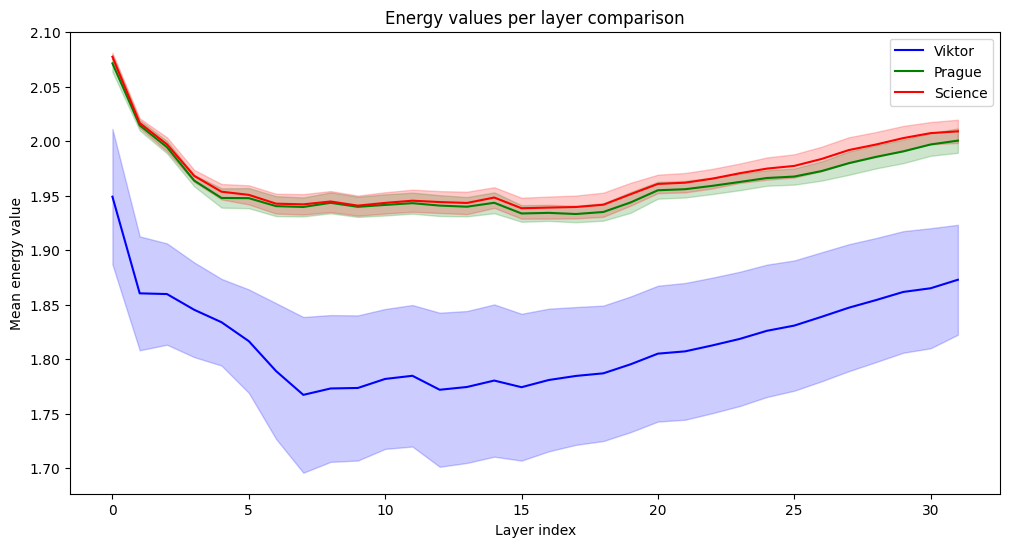

In [ ]:
mean_and_std_by_layer_plots(all_lists=first_prompt_gens)

#### Max-min bar plots

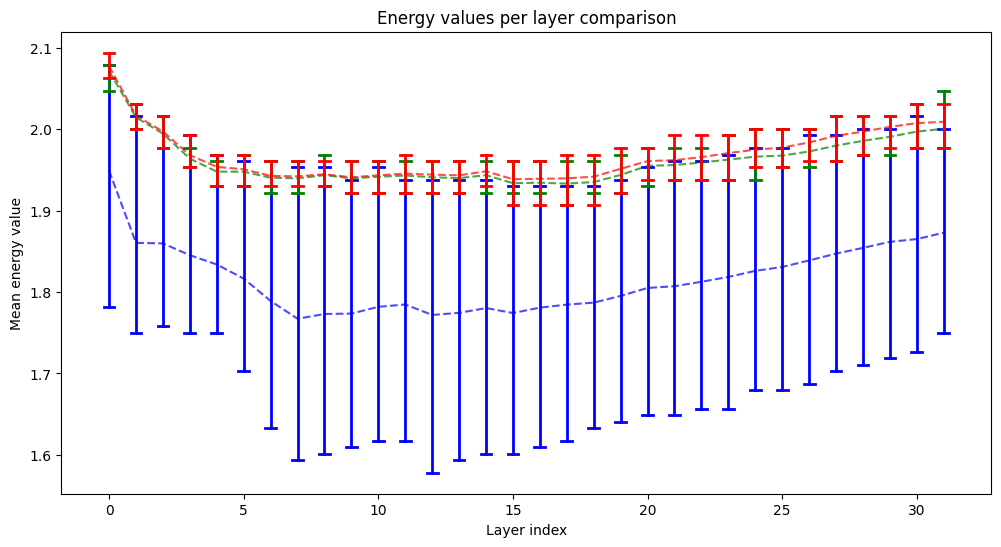

In [21]:
bar_per_layer_plots(all_lists=first_prompt_gens)

## Prompt-generated vs Shuffled

We don't have the decoded versions of the prompt-based generations, we only have the encoded tokens, so we need to obtain new generations!

In [20]:
def split_sentences(text):
    """
    Fast splitter on . ! ?
    """
    text = text.strip()
    if not text:
        return []
    sents = re.split(r'(?<=[.!?])\s+', text)
    return [s for s in sents if s]

def shuffle_sentences(text, rng):
    sents = split_sentences(text)
    if len(sents) <= 1:
        return text
    
    shuffled = sents[:] #copy
    #rng.shuffle(shuffled)
    random.shuffle(shuffled)

    #ensure itss actually different 
    if shuffled == sents:
        shuffled = sents[1:] + sents[:1]
    return " ".join(shuffled) #join sentences again

def load_prompt_and_gen(prompt_type, prompt_topic, tokenizer, terminators, device):
    prompt = load_prompts(prompt_type, prompt_topic)
    model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
    gen_ids = llama_gen(model, model_inputs, tokenizer, terminators, num_generations=100)

    return gen_ids, model_inputs

def gen_ids_to_decoded(tokenizer, model_inputs, gen_ids):
    prompt_text = tokenizer.decode(model_inputs['input_ids'][0], skip_special_tokens=True)
    decoded_gens = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

    return [decoded_generation[len(prompt_text):] for decoded_generation in decoded_gens] #list of decoded stories

def shuffle_and_encode(rng, decoded_stories, gen_ids, tokenizer):

    shuffled_stories = [shuffle_sentences(s, rng) for s in decoded_stories]
    nr_gens = len(shuffled_stories)
    max_gen_size = int(getattr(gen_ids, "shape", [nr_gens, 0])[1])  

    shuffled_encoded = tokenizer(
        shuffled_stories,
        add_special_tokens=False,         
        padding="max_length",
        truncation=True,
        max_length=max_gen_size,
        return_tensors="pt",
    )
    shuffled_input_ids = shuffled_encoded["input_ids"]
    shuffled_input_ids = shuffled_input_ids.to(device)   

    return shuffled_input_ids

def prompt_to_shuffled(prompt_type, prompt_topic, tokenizer, terminators, device, rng):
    
    gen_ids, model_inputs = load_prompt_and_gen(prompt_type, prompt_topic, tokenizer, terminators, device)

    decoded_stories = gen_ids_to_decoded(tokenizer, model_inputs, gen_ids)
    shuffled_input_ids = shuffle_and_encode(rng, decoded_stories, gen_ids, tokenizer)

    return model_inputs, gen_ids, shuffled_input_ids

def get_special_ids_set(tokenizer):
    #ensure pad_token_id at least exists
    if getattr(tokenizer, "pad_token_id", None) is None:
        raise ValueError("tokenizer.pad_token_id is not set. Set it or use a tokenizer with pad token.")
    
    return set(tokenizer.all_special_ids)

def strip_special_tokens(tensor_ids, tokenizer):
    clean_sequences = []
    lengths = []
    N, L = tensor_ids.shape
    special_ids = get_special_ids_set(tokenizer)

    for i in range(N):
        row = tensor_ids[i]
        ids = row.tolist()

        first, last = None, None
        for idx, tok in enumerate(ids): #find first non special token
            if tok not in special_ids:
                first = idx #save it
                break
    
        for idx in range(len(ids)-1, -1, -1): #iterate from the back of the tensor 
            if ids[idx] not in special_ids: #until a normal token
                last = idx #save it
                break
            
        seq = row[first:last+1].clone()
        clean_sequences.append(seq)
        lengths.append(seq.shape[0])

        return clean_sequences, lengths
    
def inference_loop(gen_ids, model_inputs, tokenizer, shuffle = False, skip_tokens = False):

    coherence_energies =[]
    tensor_size_prompt = model_inputs['input_ids'].shape[1]

    gen_only = gen_ids.clone()
    if shuffle == False:
        gen_only = gen_ids[:, tensor_size_prompt:]

    if skip_tokens == True:
        clean_sequences, _ = strip_special_tokens(gen_only, tokenizer)

        for seq in clean_sequences:
            if seq.numel() == 0:
                #handle empty generation 
                continue
            tensor = seq.unsqueeze(0)  #shape [1, seq_len]
            activations = inference_activations(model, tensor)   
            coherence_energies.append(energy_pipeline_layer(activations))
        return coherence_energies
    
    else:
        for i in range(gen_only.shape[0]):
            tensor = gen_only[i].unsqueeze(0)
            activations = inference_activations(model,tensor)
            coherence_energies.append(energy_pipeline_layer(activations))
        
        return coherence_energies
    

def per_layer_variance(energy_list, unbiased=False):
    """
    Compute variance per layer across multiple generations.

    Parameters
    ----------
    energy_list : list of torch.Tensor
        List of 1D (num_layers,) tensors — one tensor per generation.
        If tensors have extra dims, they will be flattened to 1D.
    unbiased : bool
        If False (default) computes population variance (divide by N).
        If True computes sample variance (divide by N-1).

    Returns
    -------
    torch.Tensor
        1D tensor of shape (num_layers,) containing variance for each layer.
    """
    if not energy_list:
        raise ValueError("energy_list is empty")

    processed = []
    for t in energy_list:
        if not isinstance(t, torch.Tensor):
            raise TypeError("All items in energy_list must be torch.Tensor")
        processed.append(t.to(torch.float32).flatten())

    stacked = torch.stack(processed, dim=0)  # (generations, layers)
    var_per_layer = torch.var(stacked, dim=0, unbiased=unbiased)

    return var_per_layer

def plot_layer_variance(all_lists):
    plt.figure(figsize=(10, 6))

    for name, energy_list, color in all_lists:
        var_tensor = per_layer_variance(energy_list)
        x = np.arange(len(var_tensor))
        plt.plot(x, var_tensor.numpy(), label=name, color=color)

    plt.xlabel("Layer index")
    plt.ylabel("Variance")
    plt.title("Per-layer Variance Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
tokenizer.padding_side = "right"

viktor_model_inputs, viktor_ids, shuffled_viktor_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="viktor", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
viktor_energies_right = inference_loop(viktor_ids, viktor_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_viktor_energies_right = inference_loop(shuffled_viktor_ids, viktor_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

In [12]:
tokenizer.padding_side = "left"

viktor_model_inputs, viktor_ids, shuffled_viktor_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="viktor", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
viktor_energies_left = inference_loop(viktor_ids, viktor_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_viktor_energies_left = inference_loop(shuffled_viktor_ids, viktor_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

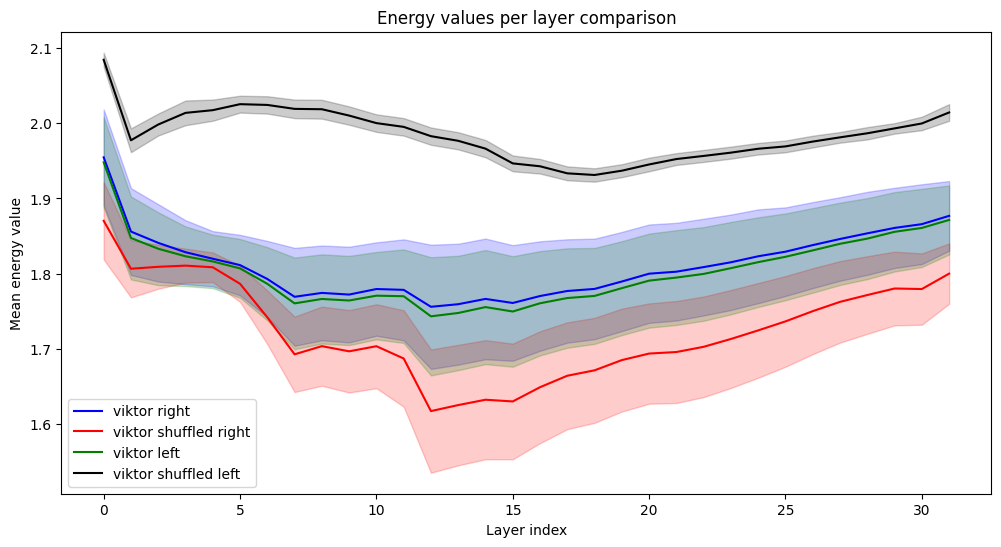

In [ ]:
#both padding on left
plt.figure(figsize=(12, 6))

viktor_lists = [
    ("viktor right", viktor_energies_right, "blue"),
    ("viktor shuffled right", shuffled_viktor_energies_right, "red"),
    ("viktor left", viktor_energies_left, "green"),
    ("viktor shuffled left", shuffled_viktor_energies_left, "black"),
]

for name, energy_list, color in viktor_lists:
    # Stack tensors to 2D array and convert to float32
    data = torch.stack([t.float() for t in energy_list]).numpy()
    
    # Compute mean and std across layers (or generations) for each neuron index
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    
    x = np.arange(data.shape[1])
    
    # Plot mean line with shaded variance
    plt.plot(x, mean_vals, label=name, color=color)
    plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

plt.xlabel('Layer index')
plt.ylabel('Mean energy value')
plt.title('Energy values per layer comparison')
plt.legend()
plt.show()

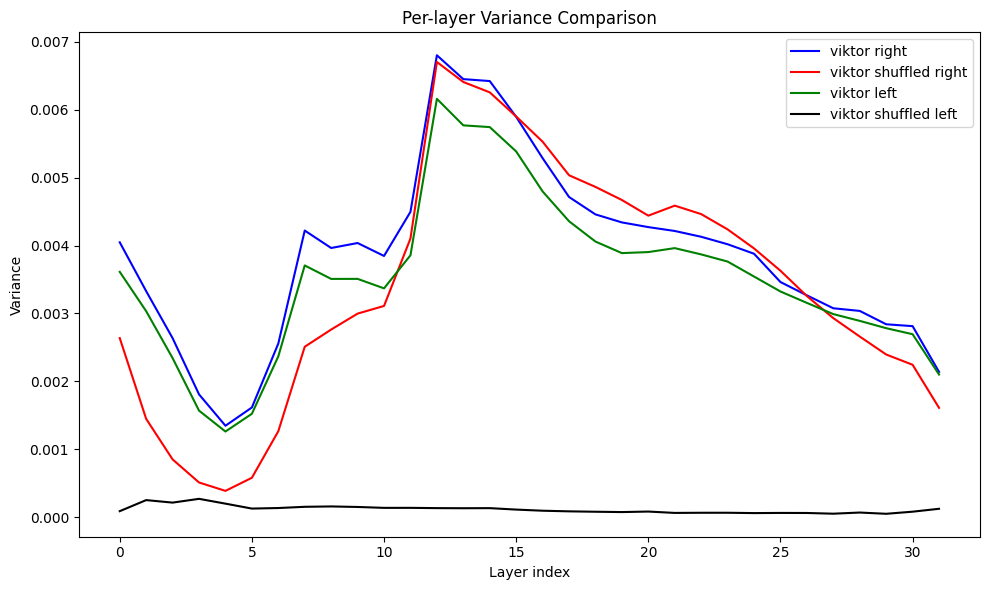

In [16]:
plot_layer_variance(all_lists=viktor_lists)

#### save

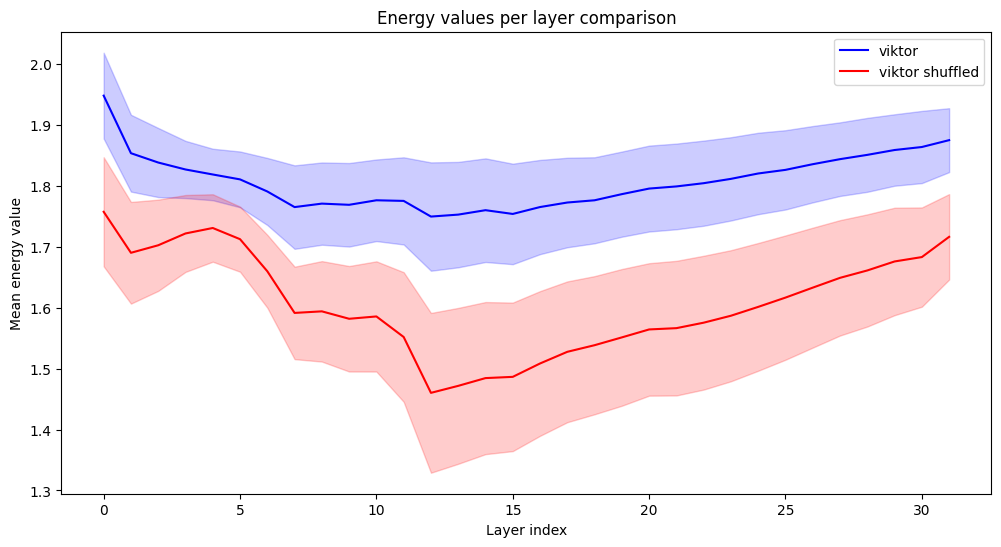

In [26]:
#both padding on right
plt.figure(figsize=(12, 6))

all_lists = [
    ("viktor", good_viktor, "blue"),
    ("viktor shuffled", bad_viktor, "red"),
]

for name, energy_list, color in all_lists:
    # Stack tensors to 2D array and convert to float32
    data = torch.stack([t.float() for t in energy_list]).numpy()
    
    # Compute mean and std across layers (or generations) for each neuron index
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    
    x = np.arange(data.shape[1])
    
    # Plot mean line with shaded variance
    plt.plot(x, mean_vals, label=name, color=color)
    plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

plt.xlabel('Layer index')
plt.ylabel('Mean energy value')
plt.title('Energy values per layer comparison')
plt.legend()
plt.show()

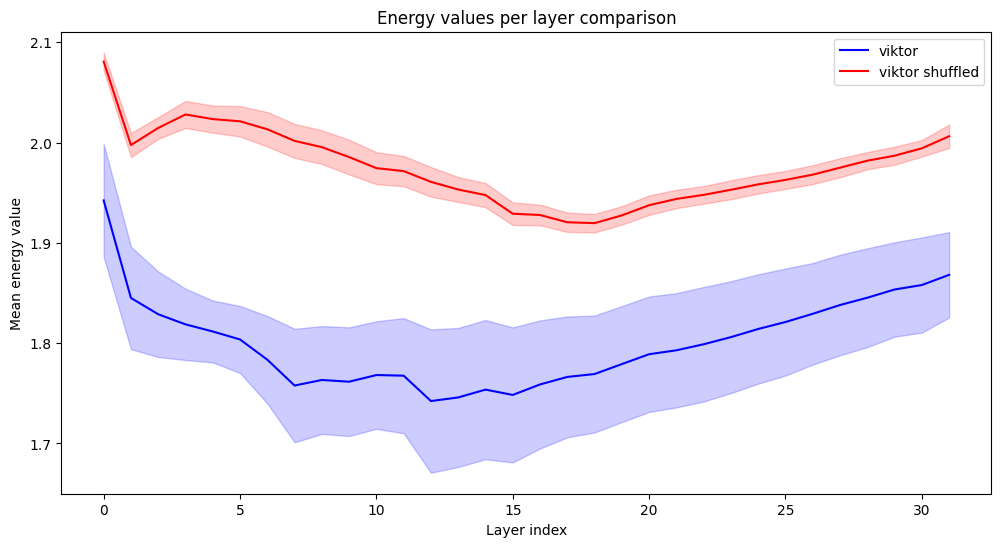

In [30]:
#both padding on left
plt.figure(figsize=(12, 6))

all_lists = [
    ("viktor", good_viktor, "blue"),
    ("viktor shuffled", bad_viktor, "red"),
]

for name, energy_list, color in all_lists:
    # Stack tensors to 2D array and convert to float32
    data = torch.stack([t.float() for t in energy_list]).numpy()
    
    # Compute mean and std across layers (or generations) for each neuron index
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    
    x = np.arange(data.shape[1])
    
    # Plot mean line with shaded variance
    plt.plot(x, mean_vals, label=name, color=color)
    plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

plt.xlabel('Layer index')
plt.ylabel('Mean energy value')
plt.title('Energy values per layer comparison')
plt.legend()
plt.show()

## TO change

In [19]:
def gen_prompt_and_shuffle(prompt_type, prompt_topic, tokenizer, device, terminators, num_gens = 100):
    prompt = load_prompts(prompt_type, prompt_topic)
    model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
    tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size
    gen_ids = llama_gen(model, model_inputs, tokenizer, terminators, num_generations=num_gens)

    prompt_text = tokenizer.decode(model_inputs['input_ids'][0], skip_special_tokens=True)
    decoded_gens = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
    decoded_stories = [decoded_generation[len(prompt_text):] for decoded_generation in decoded_gens] 

    shuffled_stories = [shuffle_sentences(s, rng) for s in decoded_stories]
    # 2) Fix padding config (LLaMA often lacks a pad token)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    # 3) Choose target shape from your original generations
    nr_gens = len(shuffled_stories)
    max_gen_size = int(getattr(gen_ids, "shape", [nr_gens, 0])[1])  # fallback if needed

    # 4) Re-encode to tensors with fixed length [nr_gens, max_gen_size]
    enc = tokenizer(
        shuffled_stories,
        add_special_tokens=False,         # keep it pure story content; set True if you want BOS/EOS
        padding="max_length",
        truncation=True,
        max_length=max_gen_size,
        return_tensors="pt",
    )

    shuffled_input_ids: torch.Tensor = enc["input_ids"]         # torch.Size([nr_gens, max_gen_size])
    shuffled_attention_mask: torch.Tensor = enc["attention_mask"]

    assert shuffled_input_ids.shape == (nr_gens, max_gen_size), shuffled_input_ids.shape

    shuffled_input_ids = shuffled_input_ids.to(device)   

    good_energies = []
    for i in range(gen_ids.shape[0]):
        tensor = gen_ids[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
        activations = inference_activations(model,tensor)
        good_energies.append(energy_pipeline_layer(activations))

    bad_energies = []
    for i in range(shuffled_input_ids.shape[0]):
        tensor = shuffled_input_ids[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
        activations = inference_activations(model,tensor)
        bad_energies.append(energy_pipeline_layer(activations))

    return good_energies, bad_energies

def good_and_shuffle_plot(all_lists):
    """ all_lists = [("Science Fiction", good_energies, "blue"),
    ("Science Fiction shuffled", bad_energies, "red")]
    """
    plt.figure(figsize=(12, 6))

    for name, energy_list, color in all_lists:
        # Stack tensors to 2D array and convert to float32
        data = torch.stack([t.float() for t in energy_list]).numpy()
        
        # Compute mean and std across layers (or generations) for each neuron index
        mean_vals = np.mean(data, axis=0)
        std_vals = np.std(data, axis=0)
        
        x = np.arange(data.shape[1])
        
        # Plot mean line with shaded variance
        plt.plot(x, mean_vals, label=name, color=color)
        plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

    plt.xlabel('Layer index')
    plt.ylabel('Mean energy value')
    plt.title('Energy values per layer comparison')
    plt.legend()
    plt.show()


def per_layer_ttests(listA, listB, alpha=0.05):
    """
    Compare two sets of activations per layer using t-tests with FDR correction.
    
    listA, listB: lists of PyTorch tensors (1x52 or 52,)
    alpha: significance level for FDR-corrected p-values
    """
    # Ensure tensors are 2D and float32
    A = torch.cat([x.unsqueeze(0).to(torch.float32) if x.ndim == 1 else x.to(torch.float32) for x in listA], dim=0).cpu().numpy()
    B = torch.cat([x.unsqueeze(0).to(torch.float32) if x.ndim == 1 else x.to(torch.float32) for x in listB], dim=0).cpu().numpy()
    
    pvals = []
    for col in range(A.shape[1]):
        _, p = ttest_ind(A[:, col], B[:, col], equal_var=False)
        pvals.append(p)
    
    # Multiple comparison correction (FDR)
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    
    results = {
        "pvals_raw": pvals,
        "pvals_corrected": pvals_corrected.tolist(),
        "significant_layers": [i for i, sig in enumerate(reject) if sig]
    }
    
    return results

In [ ]:
good_science, bad_science = gen_prompt_and_shuffle(prompt_type='generation', prompt_topic='sciencefic', tokenizer=tokenizer, device=device, terminators=terminators, num_gens = 100)

In [ ]:
science_list = [("Science Fiction", good_science, "blue"),("Science Fiction Shuffled", bad_science, "red")]
good_and_shuffle_plot(all_lists=science_list)
plot_layer_variance(all_lists=science_list)

In [ ]:
good_prague, bad_prague = gen_prompt_and_shuffle(prompt_type='generation', prompt_topic='prague', tokenizer=tokenizer, device=device, terminators=terminators, num_gens = 100)

In [ ]:
prague_list = [("Prague", good_prague, "blue"),("Prague Shuffled", bad_prague, "red")]
good_and_shuffle_plot(all_lists=prague_list)
plot_layer_variance(all_lists=prague_list)

In [ ]:
good_viktor, bad_viktor = gen_prompt_and_shuffle(prompt_type='generation', prompt_topic='viktor', tokenizer=tokenizer, device=device, terminators=terminators, num_gens = 100)

In [ ]:
viktor_list = [("Viktor", good_viktor, "blue"),("Viktor Shuffled", bad_viktor, "red")]
good_and_shuffle_plot(all_lists=viktor_list)
plot_layer_variance(all_lists=viktor_list)

## Paraphrased vs Shuffled paraphrased

In [ ]:
dir_path = "../rephrasings"

all_stories = {}
all_shuffled = {}
for i in range(1, 4):
    file = f"story{i}.json"
    shuffled_file = f"shuffled_story{i}.json"
    path = os.path.join(dir_path,file)
    shuffled_path = os.path.join(dir_path,shuffled_file)
    with open(path, "r", encoding="utf-8") as f:
        all_stories[i] = json.load(f)
    with open(shuffled_path, "r", encoding="utf-8") as f:
        all_shuffled[i] = json.load(f)

In [ ]:
def remove_clause_numbers(story: str) -> str:
    #d+ - one or more digits, \. - dot, \s* - newlines and spaces
    cleaned = re.sub(r"\d+\.\s*", "", story) 
    #remove additional spaces
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

cleaned_stories_1 = [remove_clause_numbers(story) for story in all_stories[1]]
cleaned_stories_2 = [remove_clause_numbers(story) for story in all_stories[2]]
cleaned_stories_3 = [remove_clause_numbers(story) for story in all_stories[3]]

In [ ]:
shuffled_1 = all_shuffled[1]
shuffled_2 = all_shuffled[2]
shuffled_3 = all_shuffled[3]

In [ ]:
def tokenize_to_infer(text,tokenizer):
    tokens = tokenizer(text, padding="longest", return_tensors="pt") #transform into pt tensors
    return {key: val.to(device) for key, val in tokens.items()} #move inputs into cuda

In [ ]:
tokens_clean1 = tokenize_to_infer(cleaned_stories_1,tokenizer)
tokens_clean2 = tokenize_to_infer(cleaned_stories_2,tokenizer)
tokens_clean3 = tokenize_to_infer(cleaned_stories_3,tokenizer)

tokens_shuffled1 = tokenize_to_infer(shuffled_1,tokenizer)
tokens_shuffled2 = tokenize_to_infer(shuffled_2,tokenizer)
tokens_shuffled3 = tokenize_to_infer(shuffled_3,tokenizer)

In [ ]:
def energy_loop_from_json(tokens, model):
    energy = []
    for i in range(tokens['input_ids'].shape[0]):
        activations = inference_activations(model,tokens["input_ids"][i,:].unsqueeze(0))
        energy.append(energy_pipeline_layer(activations))
    return energy

In [ ]:
energy_clean1 = energy_loop_from_json(tokens_clean1, model)
energy_clean2 = energy_loop_from_json(tokens_clean2, model)
energy_clean3 = energy_loop_from_json(tokens_clean3, model)
energy_shuffled1 = energy_loop_from_json(tokens_shuffled1, model)
energy_shuffled2 = energy_loop_from_json(tokens_shuffled2, model)
energy_shuffled3 = energy_loop_from_json(tokens_shuffled3, model)

In [ ]:
all_lists = [
    ("Clean 1", energy_clean1, "blue"),
    ("Clean 2", energy_clean2, "green"),
    ("Clean 3", energy_clean3, "red"),
    ("Shuffled 1", energy_shuffled1, "orange"),
    ("Shuffled 2", energy_shuffled2, "purple"),
    ("Shuffled 3", energy_shuffled3, "brown")
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#mean ± std
ax = axes[0]
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    x = np.arange(data.shape[1])
    
    ax.plot(x, mean_vals, label=name, color=color)
    ax.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

ax.set_xlabel('Layer index')
ax.set_ylabel('Mean energy value')
ax.set_title('Mean ± Std per layer')
ax.legend()

#min-max range
ax = axes[1]
cap_width = 0.2
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    mean_vals = np.mean(data, axis=0)
    x = np.arange(data.shape[1])
    
    for xi, vmin, vmax in zip(x, min_vals, max_vals):
        ax.plot([xi, xi], [vmin, vmax], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmin, vmin], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmax, vmax], color=color, linewidth=2)
    
    ax.plot(x, mean_vals, color=color, linestyle='--', alpha=0.7)

ax.set_xlabel('Layer index')
ax.set_ylabel('Energy value')
ax.set_title('Min-Max per layer')

plt.tight_layout()
plt.show()

In [ ]:
all_lists = [
    ("Clean 1", energy_clean1, "blue"),
    ("Shuffled 1", energy_shuffled1, "orange"),
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6)) 

#mean ± std
ax = axes[0]
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    x = np.arange(data.shape[1])
    
    ax.plot(x, mean_vals, label=name, color=color)
    ax.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

ax.set_xlabel('Layer index')
ax.set_ylabel('Mean energy value')
ax.set_title('Mean ± Std per layer')
ax.legend()

#min-max range
ax = axes[1]
cap_width = 0.2
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    mean_vals = np.mean(data, axis=0)
    x = np.arange(data.shape[1])
    
    for xi, vmin, vmax in zip(x, min_vals, max_vals):
        ax.plot([xi, xi], [vmin, vmax], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmin, vmin], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmax, vmax], color=color, linewidth=2)
    
    ax.plot(x, mean_vals, color=color, linestyle='--', alpha=0.7)

ax.set_xlabel('Layer index')
ax.set_ylabel('Energy value')
ax.set_title('Min-Max per layer')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

#variance
plt.figure(figsize=(10, 6))

for name, energy_list, color in all_lists:
    var_tensor = per_layer_variance(energy_list)
    x = np.arange(len(var_tensor))
    plt.plot(x, var_tensor.numpy(), label=name, color=color)

plt.xlabel("Layer index")
plt.ylabel("Variance")
plt.title("Per-layer Variance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results = per_layer_ttests(energy_clean1, energy_shuffled1)

print("Significant layers (after FDR correction):", results["significant_layers"])
print("Corrected p-values:", results["pvals_corrected"])

In [ ]:
all_lists = [
    ("Clean 2", energy_clean2, "green"),
    ("Shuffled 2", energy_shuffled2, "purple"),
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#mean ± std
ax = axes[0]
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    x = np.arange(data.shape[1])
    
    ax.plot(x, mean_vals, label=name, color=color)
    ax.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

ax.set_xlabel('Layer index')
ax.set_ylabel('Mean energy value')
ax.set_title('Mean ± Std per layer')
ax.legend()

#min-max range
ax = axes[1]
cap_width = 0.2
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    mean_vals = np.mean(data, axis=0)
    x = np.arange(data.shape[1])
    
    for xi, vmin, vmax in zip(x, min_vals, max_vals):
        ax.plot([xi, xi], [vmin, vmax], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmin, vmin], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmax, vmax], color=color, linewidth=2)
    
    ax.plot(x, mean_vals, color=color, linestyle='--', alpha=0.7)

ax.set_xlabel('Layer index')
ax.set_ylabel('Energy value')
ax.set_title('Min-Max per layer')

plt.tight_layout()
plt.show()

#variance
plt.figure(figsize=(10, 6))

for name, energy_list, color in all_lists:
    var_tensor = per_layer_variance(energy_list)
    x = np.arange(len(var_tensor))
    plt.plot(x, var_tensor.numpy(), label=name, color=color)

plt.xlabel("Layer index")
plt.ylabel("Variance")
plt.title("Per-layer Variance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results = per_layer_ttests(energy_clean2, energy_shuffled2)

print("Significant layers (after FDR correction):", results["significant_layers"])
print("Corrected p-values:", results["pvals_corrected"])

In [ ]:
all_lists = [
    ("Clean 3", energy_clean3, "red"),
    ("Shuffled 3", energy_shuffled3, "brown")
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

#mean ± std
ax = axes[0]
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    x = np.arange(data.shape[1])
    
    ax.plot(x, mean_vals, label=name, color=color)
    ax.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

ax.set_xlabel('Layer index')
ax.set_ylabel('Mean energy value')
ax.set_title('Mean ± Std per layer')
ax.legend()

#min-max range
ax = axes[1]
cap_width = 0.2
for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    mean_vals = np.mean(data, axis=0)
    x = np.arange(data.shape[1])
    
    for xi, vmin, vmax in zip(x, min_vals, max_vals):
        ax.plot([xi, xi], [vmin, vmax], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmin, vmin], color=color, linewidth=2)
        ax.plot([xi - cap_width, xi + cap_width], [vmax, vmax], color=color, linewidth=2)
    
    ax.plot(x, mean_vals, color=color, linestyle='--', alpha=0.7)

ax.set_xlabel('Layer index')
ax.set_ylabel('Energy value')
ax.set_title('Min-Max per layer')

plt.tight_layout()
plt.show()

#variance
plt.figure(figsize=(10, 6))

for name, energy_list, color in all_lists:
    var_tensor = per_layer_variance(energy_list)
    x = np.arange(len(var_tensor))
    plt.plot(x, var_tensor.numpy(), label=name, color=color)

plt.xlabel("Layer index")
plt.ylabel("Variance")
plt.title("Per-layer Variance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results = per_layer_ttests(energy_clean3, energy_shuffled3)

print("Significant layers (after FDR correction):", results["significant_layers"])
print("Corrected p-values:", results["pvals_corrected"])